# <center> Импорт библоиотек <center>

In [1]:
!mkdir models

A subdirectory or file models already exists.


*NOTE*: не забудьте составить список библиотек, необходимых для реализации ваших решений, и представить их в файле `requirements.txt`.

In [2]:
import pickle
import random
import json
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
# from sklearn.svm import SVC

from catboost import CatBoostClassifier

SEED = 31415
np.random.seed(SEED)
random.seed(SEED)

# <center> Чтение данных <center>

Тренировчные данные представлены в виде файла в формате JSON. В котором верхенеуровневый ключ - это номер образца (бакетрии). Каждый словарь по бактериям содержит название штамма и результаты масс-спектрометрического анализа, которые представлены следующими полями: масса к заряду (m/z), время (time), интенсивность пика (Intens.), разрешение (Res.), площадь пика (Area), относительная интенсивность (Rel. Intens.), ширина на полувысоте (FWHM=full width at half-maximum intensity). Каждый штамм будет представлен несколькими бактериями.

In [3]:
# with open('../input/ai4biology/train.json', 'rb') as fp:
with open('../input/train.json', 'rb') as fp:
    train_d = json.load(fp)
train_df = pd.DataFrame(json.loads(train_d)).T
train_df.drop('Bk. Peak', axis=1, inplace=True)

In [4]:
train_df.shape

(256, 9)

In [5]:
# Посмотрим сколько классов данных и сколько примеров на каждый класс
train_df.groupby('strain').agg({'strain': "count"})

,strain
strain,
Acinetobacter baumani_121 skin,9
Acinetobacter baumani_126,9
Acinetobacter baumani_352 blood,10
Acinetobacter baumani_377 blood,11
Acinetobacter baumani_503 blood,11
Acinetobacter baumani_63,9
Acinetobacter baumani_64,11
Acinetobacter baumani_73,10
Acinetobacter baumani_74,11


Так как тренировочный набор данных не очень большой, дополним его симмулированными данными. Для этого составим дополнительные примеры из существующих. Зададим seed для воспроизводимости результатов.

In [6]:
# определим количестов пиков в масс-спектрах
train_df.loc[:,'n_peak'] = train_df['m/z'].apply(len)

In [7]:
def get_dif(x: pd.Series) -> pd.Series:
    return max(x) - min(x)

In [8]:
# посмотрим на сколько по количеству строк (пиков) различаются таблицы внутри каждого штамма
peaks_dif = train_df.groupby(['strain']).agg({'n_peak': get_dif})

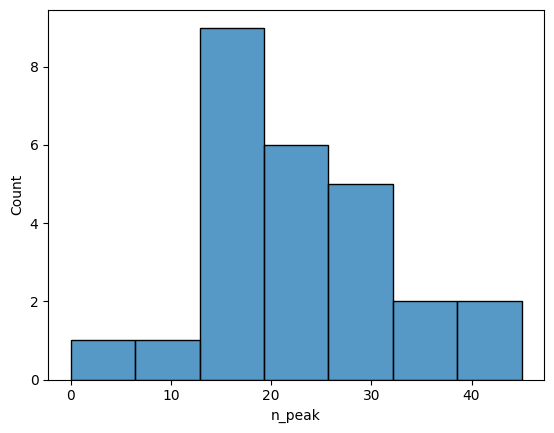

In [9]:
sns.histplot(peaks_dif.n_peak)
plt.show()

In [10]:
# будем использовать среднюю разности для варьирвания числа пиков в сгенерированных данных
mean_dif = int(peaks_dif.n_peak.mean())

In [11]:
FEATURES = ['m/z', 'time', 'Intens.', 'SN', 'Res.', 'Area', 'Rel. Intens.', 'FWHM']

In [12]:
train_gen = pd.DataFrame()
for strain in train_df.strain.unique():
    tmp = train_df[train_df.strain == strain]
    n_samples = tmp.shape[0]
    s = np.random.randint(max(tmp.n_peak) - mean_dif, max(tmp.n_peak), 6)
    strain_df = pd.DataFrame()
    
    for sample in tmp[FEATURES].values:
        tmp_i = pd.DataFrame(list(sample)).T
        tmp_i.columns = FEATURES
        strain_df = pd.concat([strain_df, tmp_i])

    for i in range(0,6):
        df_i = pd.DataFrame()
        idx = []
        for n in range(0, s[i]):
            if isinstance(strain_df.loc[n], pd.Series):
                continue
            else:
                df_i = pd.concat([df_i, strain_df.loc[n].sample(n=1)])

        df_i[['id']] = i
        df_i.loc[:, 'strain'] = tmp.strain.unique()[0]
        df_i.loc[:, 'n_peak'] = n
        train_gen = pd.concat([train_gen, df_i]) 

Совместим оригинальный датасет и сгенерированный.

In [13]:
train_gen = train_gen.groupby(['strain', 'id']).agg(list).reset_index().drop(['id'], axis = 1)
train_gen.loc[:,'n_peak'] = train_gen.n_peak.apply(min)
train_df = pd.concat([train_df, train_gen[train_df.columns]])

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18332\371837419.py:2: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  train_gen.loc[:,'n_peak'] = train_gen.n_peak.apply(min)


In [14]:
train_gen.shape

(156, 10)

In [15]:
train_df.shape

(412, 10)

# <center> Обработка данных и генерация признаков<center>

Пример таблицы с данными по масс-спектру для одного образца.

In [16]:
example = train_df[FEATURES]\
         .loc[(train_df.strain == 'Staphilococcus aureus_6 1006')].iloc[0]
example = pd.DataFrame(list(example)).T
example.columns = FEATURES

In [17]:
example.head()

,m/z,time,Intens.,SN,Res.,Area,Rel. Intens.,FWHM
0,2141.595860,46248.308185,1849.671417,5.023842,449.793188,13621.062834,0.084247,4.761290
1,2154.140758,46381.493984,1299.384644,3.529223,458.732871,9421.672911,0.059183,4.695850
2,2180.436755,46659.416149,1203.332001,3.317415,443.973316,9161.078120,0.054808,4.911189
3,2297.759326,47879.408034,1426.807159,3.967446,620.345018,9085.341876,0.064987,3.704002
4,2764.201381,52445.360112,1586.883118,4.470495,629.209920,12546.815080,0.072278,4.393131


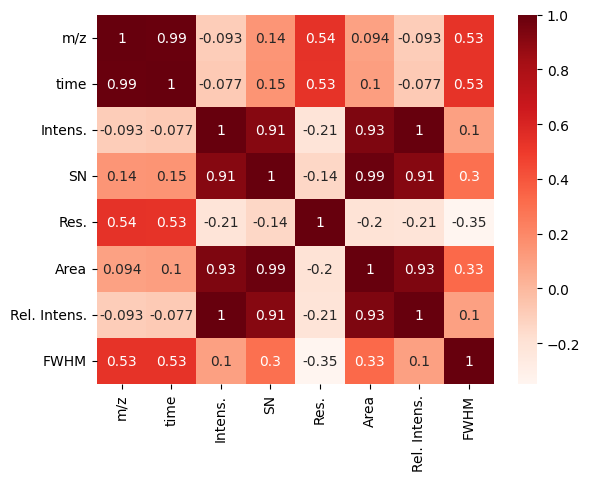

In [18]:
cor = example.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

In [19]:
# Выбор некоррелирующих признаков
FEATURES = ['m/z', 'Rel. Intens.', 'Res.', 'FWHM']

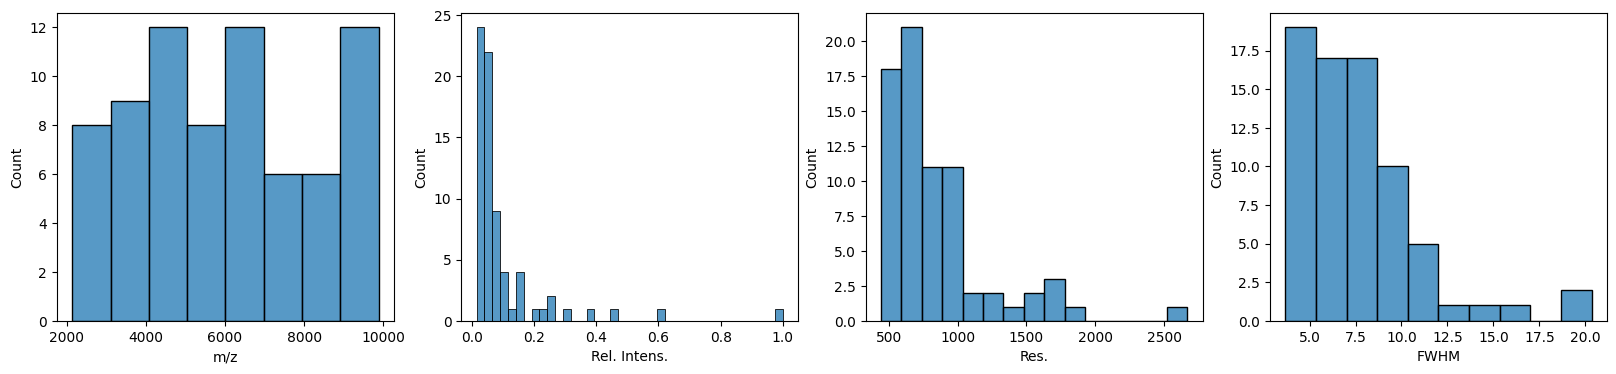

In [20]:
fig, axs = plt.subplots(1,4, figsize=(20, 4))
for features in FEATURES:
    sns.histplot(example[features], ax=axs[FEATURES.index(features)])

Посмотрим на масс-спектры для нескольих примеров

In [21]:
def colors_from_values(values: list, palette_name: str) -> np.array:
    values = np.array(values)
    normalized = (values - min(values)) / (max(values) - min(values))
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

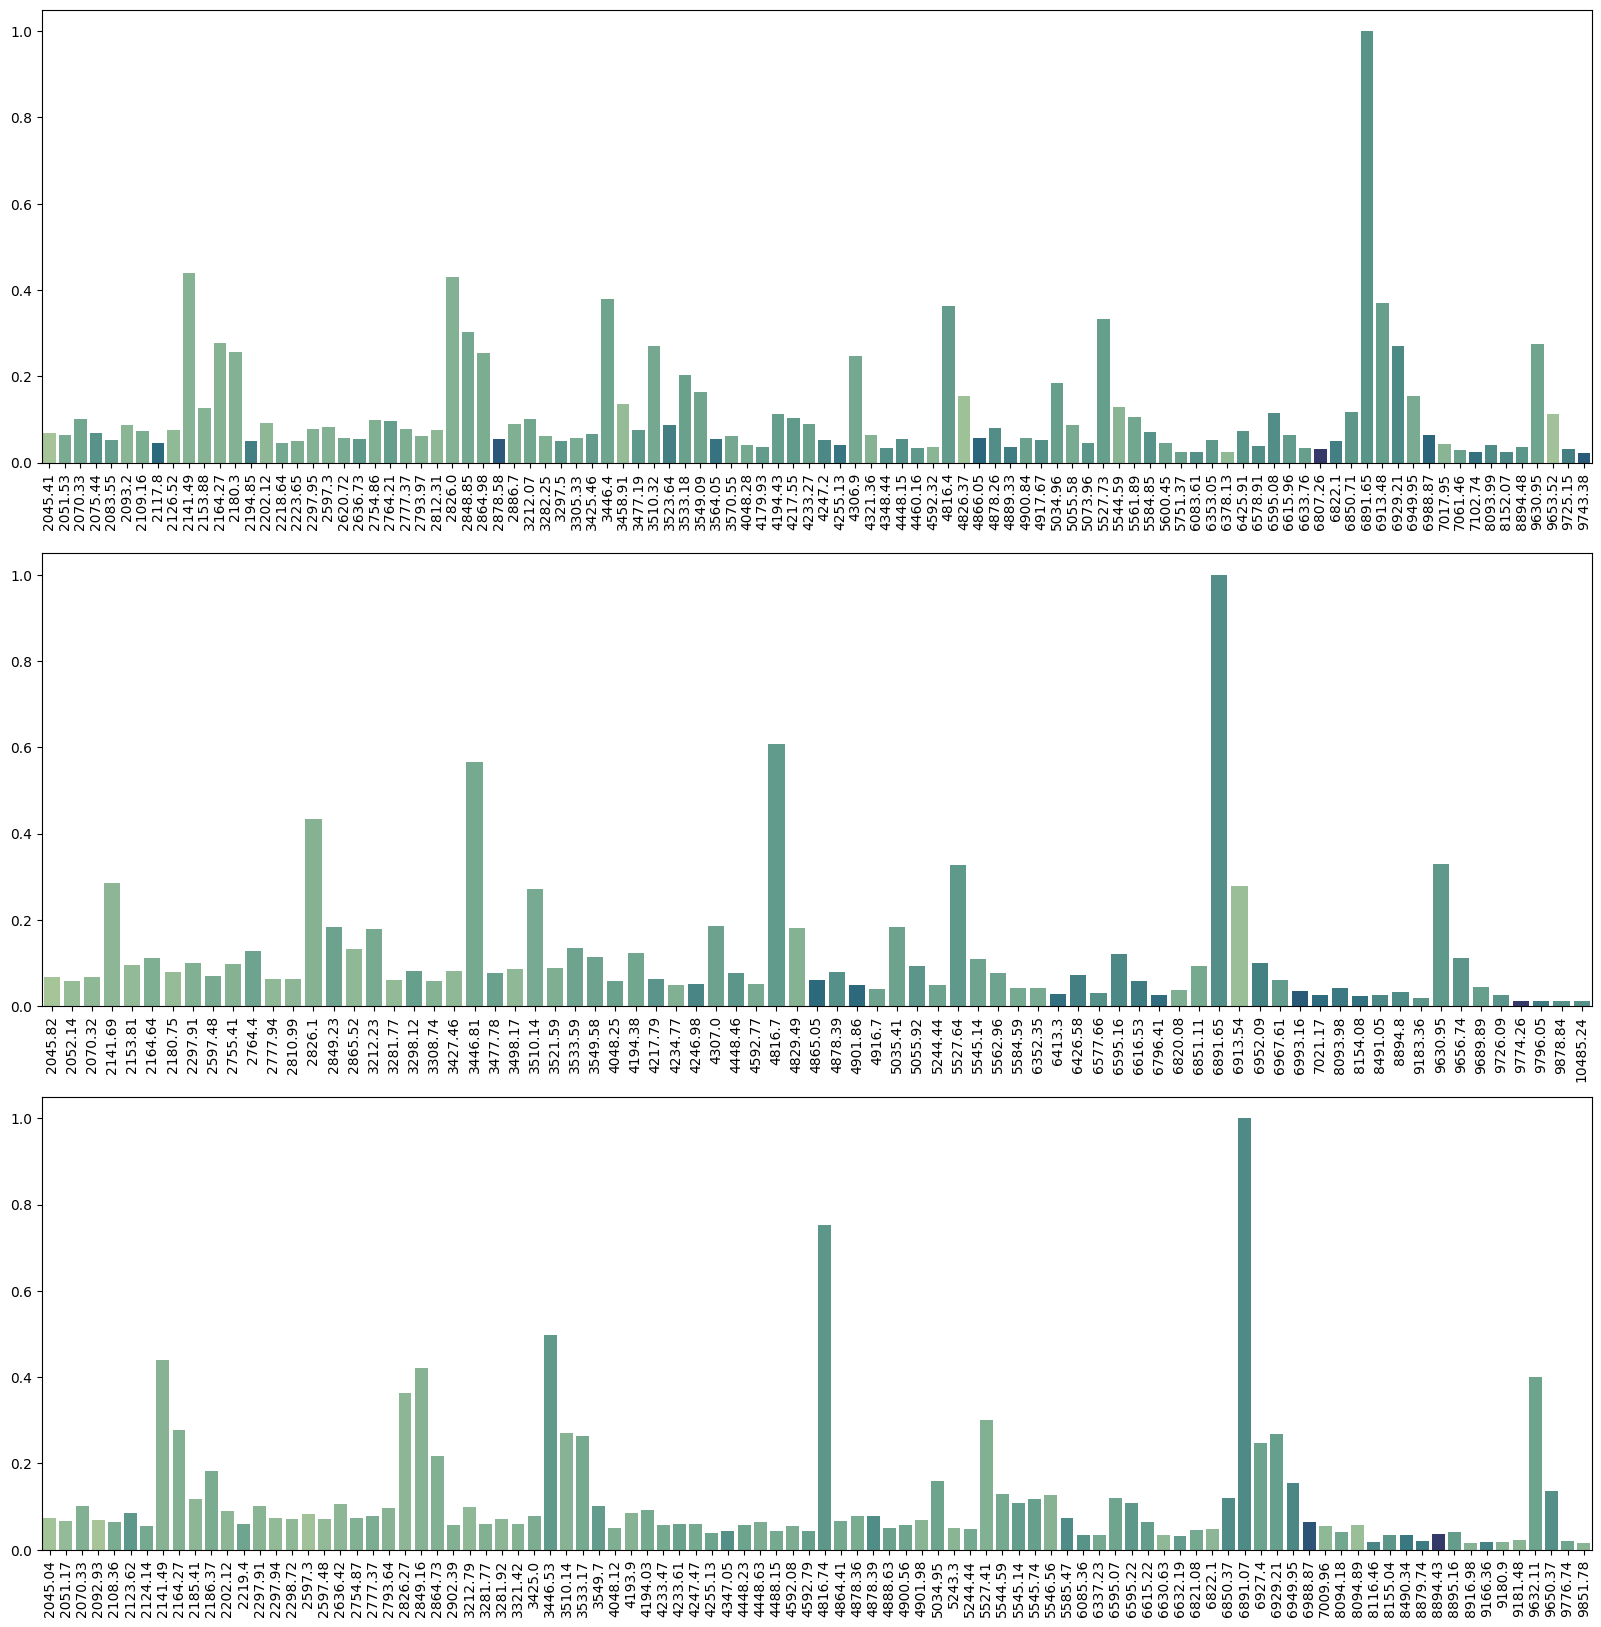

In [22]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))
satain = "Acinetobacter baumani_64"
i = 0
for ids in [2,6,8]:
    tmp = train_df.loc[(train_df.strain == strain)].iloc[ids]
    mz = [np.round(x, 2) for x in tmp['m/z']]
    ax = axs[i]
    sns.barplot(data=tmp, x=mz, y='Rel. Intens.',
                palette=colors_from_values(tmp['Res.'], 'crest'),
                ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    i += 1

Создаим спектры, которые удобно сравнитвать между собой в виде векторов в фиксированом диапазоне, и уберем необходимость использовать переменную "m/z".

In [23]:
# орпеделим диапазон парамтеров
min(train_df['m/z'].apply(min)), max(train_df['m/z'].apply(max))

(2040.804289776974, 17241.93492389016)

In [24]:
def create_speactr(mz: pd.Series, intens: pd.Series) -> pd.Series:
    spec = []
    for i in range(200, 1750):
        if i in mz:
            spec.append(intens[mz.index(i)])
        else:
            spec.append(0)
    return spec

In [25]:
def prepocess_data(data: pd.DataFrame) -> pd.DataFrame:
    data['mz'] = data['m/z'].apply(lambda x: [int(x_i // 10) for x_i in x])
    data['intens'] = data.apply(lambda d: create_speactr(d['mz'], d['Rel. Intens.']),
                           axis = 1)
    return data

In [26]:
train_df = prepocess_data(train_df)

Перемешаем данные, чтобы классы не шли по порядку.

In [27]:
train_df = train_df.sample(frac=1).reset_index(drop=True)

# <center> Обучение моделей <center>

Разобьем выборку на валидационную и тренировочную так, чтобы хотя бы один пример из каждого класса присутствавал
в валидаицонной выборке. После разбиения уберем два класса из тренировочный выборки, чтобы можно было определить их 
как 'new'.

_Note_:  рекомендуем рассмотреть разные вариатны разбиения на тренировочную и валидационную выборку для определения оптимальных параметров. 

In [28]:
val_ds = pd.DataFrame()
train_ds = pd.DataFrame()
for strain in train_df.strain.unique():
    n = np.random.randint(1, 4)
    ids = random.sample(list(train_df.loc[train_df.strain == strain].index), n)
    val_ds = pd.concat([val_ds, train_df.loc[ids]])
    train_ids = list(set(train_df.loc[train_df.strain == strain].index) - set(ids))
    train_ds = pd.concat([train_ds, train_df.loc[train_ids]])

In [29]:
val_ds.shape, train_ds.shape

((53, 12), (359, 12))

In [30]:
val_strain = random.sample(sorted(list(val_ds.strain.unique())), 2)
val_strain

['Acinetobacter baumani_377 blood', 'Staphilococcus aureus_4 948']

In [31]:
train_ds = train_ds[~train_ds.strain.isin(val_strain)]

In [32]:
val_ds.loc[:, 'target'] = val_ds.strain
val_ds.loc[val_ds.strain.isin(val_strain),'target'] = 'new'

In [33]:
val_ds = val_ds.sample(frac=1)
train_ds = train_ds.sample(frac=1)

## Многоклассовый классификатор

In [34]:
def make_x(df: pd.DataFrame, col: str) -> np.array:
    X = []
    for i in df.index:
        row = df.loc[i, col]
        X.append(row)
    return np.array(X)

In [35]:
X = make_x(train_ds, col='intens')
y = np.array(train_ds['strain'])

In [36]:
catboost_params = {'iterations': 100, 'learning_rate': 0.1,
                   'task_type': 'CPU', 'silent': True,
                   'random_seed': SEED, 'depth': 6}

In [37]:
# model = SVC(gamma='auto', kernel='sigmoid', probability=True)
model = CatBoostClassifier(loss_function='MultiClass', **catboost_params)
clf = make_pipeline(StandardScaler(), model)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000002B293BCB3A0>)])

### Проверяем качество модели на валидационной выборке

In [38]:
X_pred = make_x(val_ds, col='intens')

In [39]:
val_ds.loc[:, 'class_name'] = clf.predict(X_pred)
val_ds.loc[:, 'class_name_proba'] = np.max(clf.predict_proba(np.array(X_pred)),
                                           axis=1)

In [40]:
# посмотрим на качесто модели до выделения новых классов
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.8967619047619046

Новые классы будем орпеделять по вероятности определения класса.

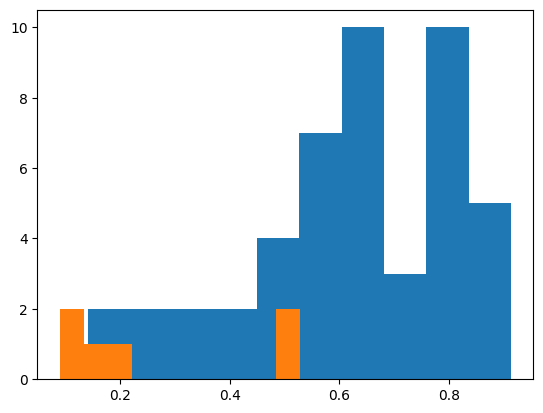

In [41]:
plt.hist(val_ds.loc[val_ds.target != 'new'].class_name_proba)
plt.hist(val_ds.loc[val_ds.target == 'new'].class_name_proba)
plt.show()

In [42]:
val_ds.loc[val_ds.class_name_proba < 0.2,'class_name'] = 'new'

In [43]:
# посмотрим на качесто модели с выделенными новыми классами
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.9520000000000001

### Сохранение модели

Переобучим модель на всей тренировочной выборке, так как мы исключали классы для валидации.

In [44]:
X = make_x(train_df, col='intens')
y = np.array(train_df['strain'])

In [45]:
# model = SVC(gamma='auto', kernel='sigmoid', probability=True)
model = CatBoostClassifier(loss_function='MultiClass', **catboost_params)
clf = make_pipeline(StandardScaler(), model)
clf.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('catboostclassifier',
                 <catboost.core.CatBoostClassifier object at 0x000002B292C8BF40>)])

In [46]:
swmPickle = open('models/baseline_clf.pkl', 'wb') 
pickle.dump(clf, swmPickle)

## Набор бинарных классификатров для каждого таргета

In [47]:
X = make_x(train_ds, col='intens')

In [48]:
# сделаем бинарный таргет для каждого класса
Y = []
for strain in train_ds.strain.unique():
    Y.append(np.array(train_ds.strain == strain))

In [49]:
# сохраняем порядок классов
class_order = train_ds.strain.unique()

Так как негативных примеров для каждого таргета в разы больше положительных, оставим в выборке только примеры в соотношении 3:1 (негативные:положительные).

In [50]:
res = []
for i, y in enumerate(Y):
    idx_pos = np.where(y == True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos, idx_neg[:3*len(idx_pos)])))

#     model = SVC(gamma='scale', probability=True)
    model = CatBoostClassifier(loss_function='MultiClassOneVsAll', **catboost_params)
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])

    res.append(clf.predict_proba(X_pred)[:, 1])

### Проверяем качество модели на валидационной выборке

In [51]:
res = np.array(res).T

In [52]:
# выбираем класс с наибольшей вероятностью или ставим 0, если вероятность меньше 0.5
class_name = []
for res_i in res:
    if max(res_i) > 0.4:
        class_name.append(class_order[np.where(res_i == max(res_i))[0]].item())
    else:
        class_name.append('new')

In [53]:
val_ds.loc[:,'class_name'] = class_name

In [54]:
f1_score(val_ds.class_name, val_ds.target, average='macro')

0.8933333333333333

Данная модель показала самое высокое значение метрики, поэтому берем ее как бейзлайн для данной задачи.

### Сохраняем модели

In [55]:
# переобучаем на полной выборке
res = []
for i, y in enumerate(Y):
    idx_pos = np.where(y ==True)[0]
    idx_neg = np.where(y == False)[0]
    random.shuffle(idx_neg)
    idx = sorted(np.concatenate((idx_pos,idx_neg[:3*len(idx_pos)])))

#     model = SVC(gamma='scale', probability=True)
    model = CatBoostClassifier(loss_function='MultiClassOneVsAll', **catboost_params)
    clf = make_pipeline(StandardScaler(), model)
    clf.fit(X[idx,:], y[idx])

    # сохраняем модель
    strain = class_order[i]
    pickle.dump(clf, open(f'models/baseline_clf_{strain}.pkl', 'wb'))

# <center> Формат решения <center>

В проверяющую систему необходимо отправить код алгоритма, запакованный в ZIP-архив. Архив должен содержать следующие файлы: 
 * solution.py -- файл с кодом запуска решения
 * models/ -- директория, где хранятся обученные модели
 * requiremnts.txt -- необходимые библиотеки для запуска решения
 * \*.py -- вспомогательные модули
 * metadata.json  -- обязательный файл для запуска докера, который содержит название docker image и команду для расчета предсказаний (см. описание задачи)
 
Решение должно быть реализовано в виде программы, которая на вход принимает файл `test.xlsx` и на выходе выдает CSV таблицу (`results.csv`). Файл `results.csv` должен в обязательном порядке содержать поле `class_name`  -- предсказанный класс (название штамма бактерии или метка 'new')